# Подготовка данных

Загружаем сырые данные, скачанные с [сайта kaggle.com](https://www.kaggle.com/code/artemboiko/5000-projects-ifc-rvt-datadrivenconstruction-io/notebook)

In [4]:
import pandas as pd

df_full = pd.read_csv("data/IFC_2000_300_Columns.csv", low_memory=False)
df_full.head()

,Unnamed: 0,Unnamed: 0.1,Filename,IfcEntity,UniqueID,IFC version,GlobalId,OwnerHistory,ObjectPlacement,Representation,...,cpiFitMatchKey,Product code,ISOCD3766ShapeCode,ISOCD3766ShapeParameter_b,Omschrijving,Flche,System Classification,qv_SizingFlow_ls,dpTot_SizingFlow_Pa,Ebene
0,0,1000,beams_ifc,OdIfc4::IfcBeamStandardCase,1000.0,IFC4,0juf4qyggSI8rxA20Qwnsj,0.0,1001.0,1010.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1100,beams_ifc,OdIfc4::IfcBeamStandardCase,1100.0,IFC4,0juf4qyggSI8rxA20sznsj,0.0,1101.0,1110.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,1200,beams_ifc,OdIfc4::IfcBeamStandardCase,1200.0,IFC4,0juf4qyggSI8s4A20sznsj,0.0,1201.0,1210.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,1300,beams_ifc,OdIfc4::IfcBeamStandardCase,1300.0,IFC4,0juf4qyggSI8s4A20sznw6,0.0,1301.0,1310.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,1400,beams_ifc,OdIfc4::IfcBeamStandardCase,1400.0,IFC4,0juf4qyggSI8rxA20Qwnab,0.0,1401.0,1410.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
# drop `Unnamed XXX` columns
df_full = df_full.drop(df_full.columns[:2], axis=1)

## Имеющиеся сущности

In [68]:
df_full['IfcEntity'] = df_full['IfcEntity'].replace(r'^(.*?)::', '', regex=True)
df_full['IfcEntity'].value_counts().head(10)

IfcEntity
IfcDiscreteAccessory       335594
IfcBeam                    240784
IfcBuildingElementProxy    119628
IfcMember                   93677
IfcMechanicalFastener       89406
IfcWallStandardCase         77179
IfcPlate                    76144
IfcColumn                   65168
IfcReinforcingBar           51490
IfcFlowTerminal             42250
Name: count, dtype: int64

## Данные по балкам

Выкидываем все колонки с константами и пропусками

In [71]:
df_beams = df_full[df_full['IfcEntity'] == 'IfcBeam']
df_beams = df_beams.dropna(axis=1, how='all')

# remove constant columns
const_columns = [col for col in df_beams.columns if df_beams[col].nunique() <= 1]
df_beams = df_beams.drop(const_columns, axis=1)
df_beams.info()

<class 'pandas.core.frame.DataFrame'>
Index: 240784 entries, 70 to 1527404
Columns: 132 entries, Filename to Ebene
dtypes: float64(53), object(79)
memory usage: 244.3+ MB


Объединяем колонки с похожими именами

In [88]:
def process_columns(df, callback):
    to_drop = []
    to_rename = {}
    for col in df.columns:
        new_col = callback(col)
        if new_col == col:
            continue

        if new_col is None:
            print(f"{col!r} -> **DELETE**")
            to_drop.append(col)
        elif new_col not in df.columns:
            print(f"{col!r} -> {new_col!r}")
            to_rename[col] = new_col
        else:
            print(f"{col!r} -> {new_col!r} (merge)")
            df[new_col] = df[new_col].fillna(df[col])
            to_drop.append(col)

    if to_drop:
        df.drop(to_drop, axis=1, inplace=True)

    if to_rename:
        df.rename(to_rename, axis=1, inplace=True)

def name_to_camel(name):
    if ' ' not in name:
        return name
    return ''.join(word.capitalize() for word in name.split(' '))

def remove_square_prefix(name):
    if not name.startswith('['):
        return name

    count = 0
    for idx, ch in enumerate(name):
        match ch:
            case '[':
                count += 1
            case ']':
                count -= 1
            case _:
                continue

        if count == 0:
            return name[idx + 1:].strip()
    raise ValueError(name)

def normalize_col_name(col):
    if col.startswith(r'\U'):
        return None
    col = remove_square_prefix(col)
    if '_' in col:
        col = col.replace('_', ' ')
    if ' ' in col:
        col = name_to_camel(col)
    return col

process_columns(df_beams, normalize_col_name)

'\\U+521B\\U+5EFA\\U+7684\\U+9636\\U+6BB5' -> **DELETE**
'\\U+9762\\U+79EF' -> **DELETE**
'\\U+4F53\\U+79EF' -> **DELETE**
'\\U+7C7B\\U+578B' -> **DELETE**
'\\U+65CF\\U+4E0E\\U+7C7B\\U+578B' -> **DELETE**
'\\U+65CF' -> **DELETE**
'\\U+957F\\U+5EA6' -> **DELETE**
'\\U+7C7B\\U+578B\\U+540D\\U+79F0' -> **DELETE**
'\\U+65CF\\U+540D\\U+79F0' -> **DELETE**
'\\U+542F\\U+7528\\U+5206\\U+6790\\U+6A21\\U+578B' -> **DELETE**


<Axes: >

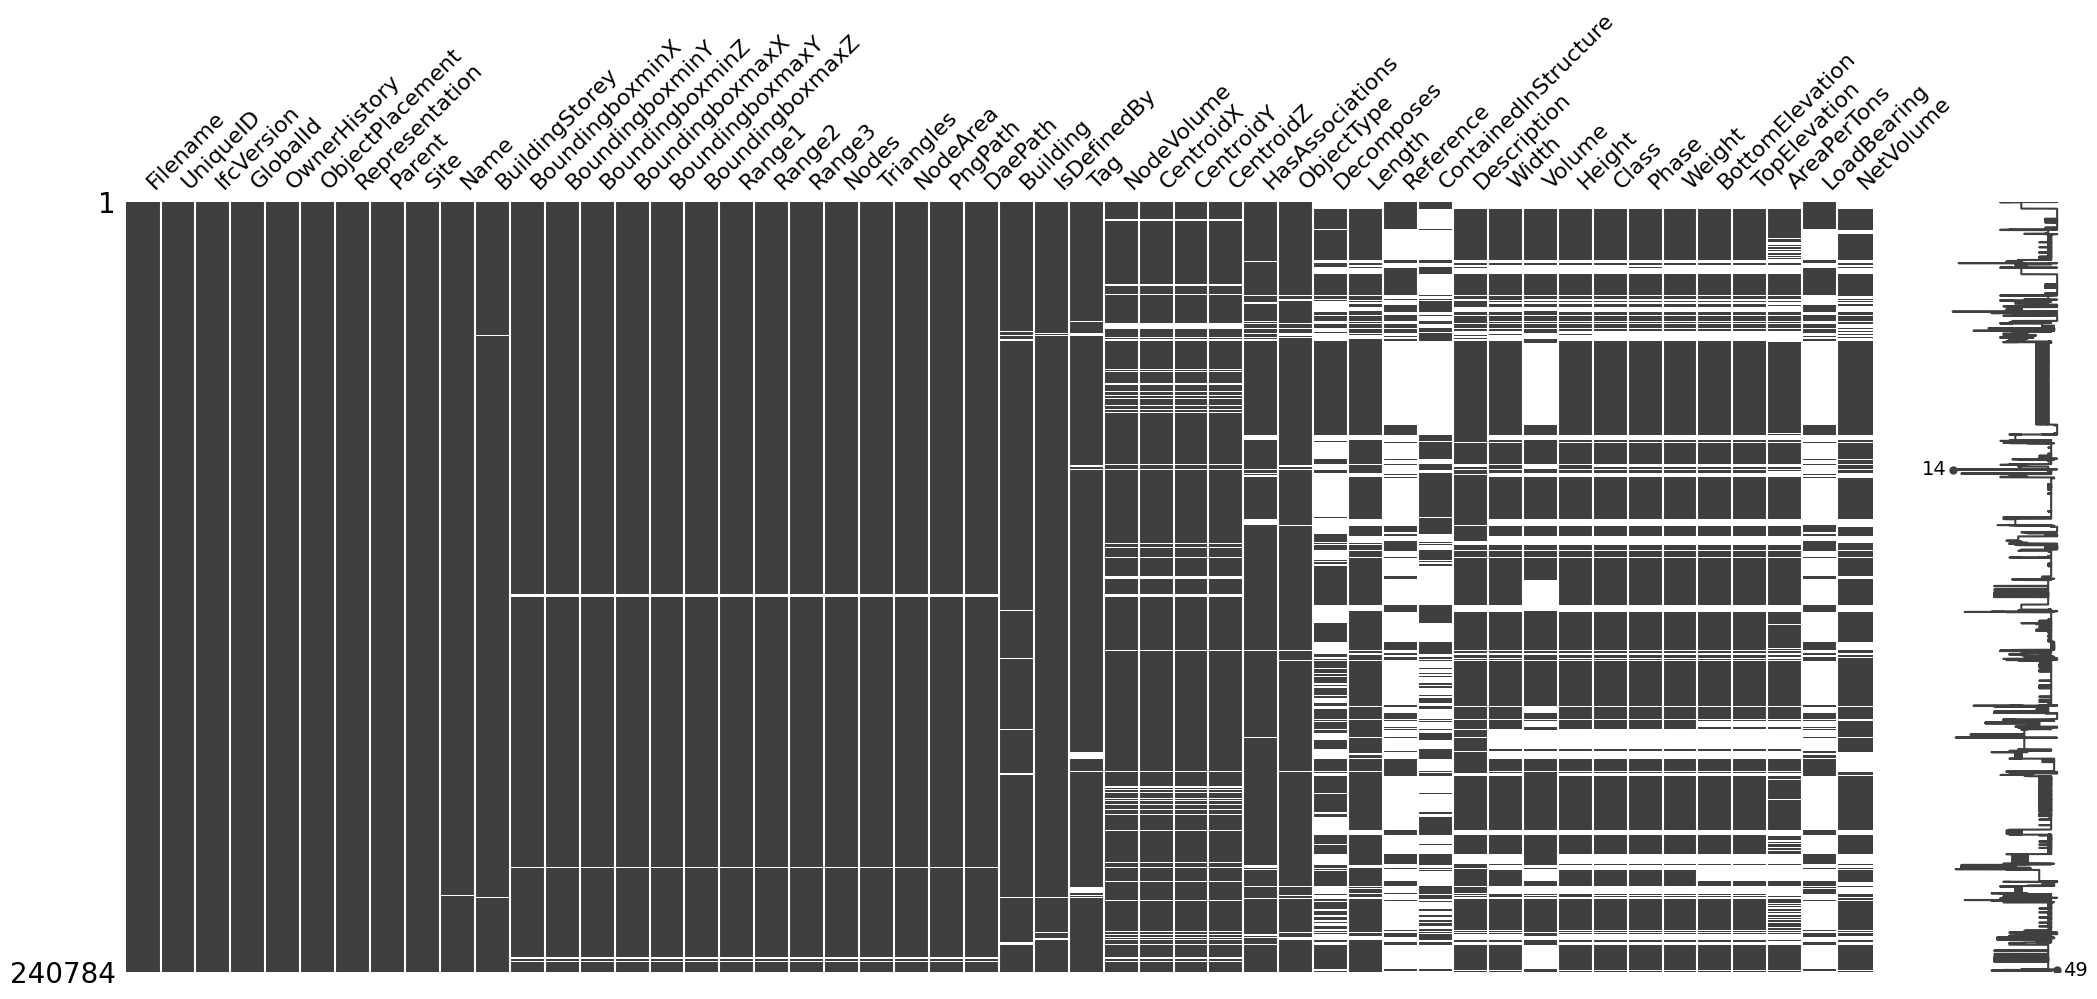

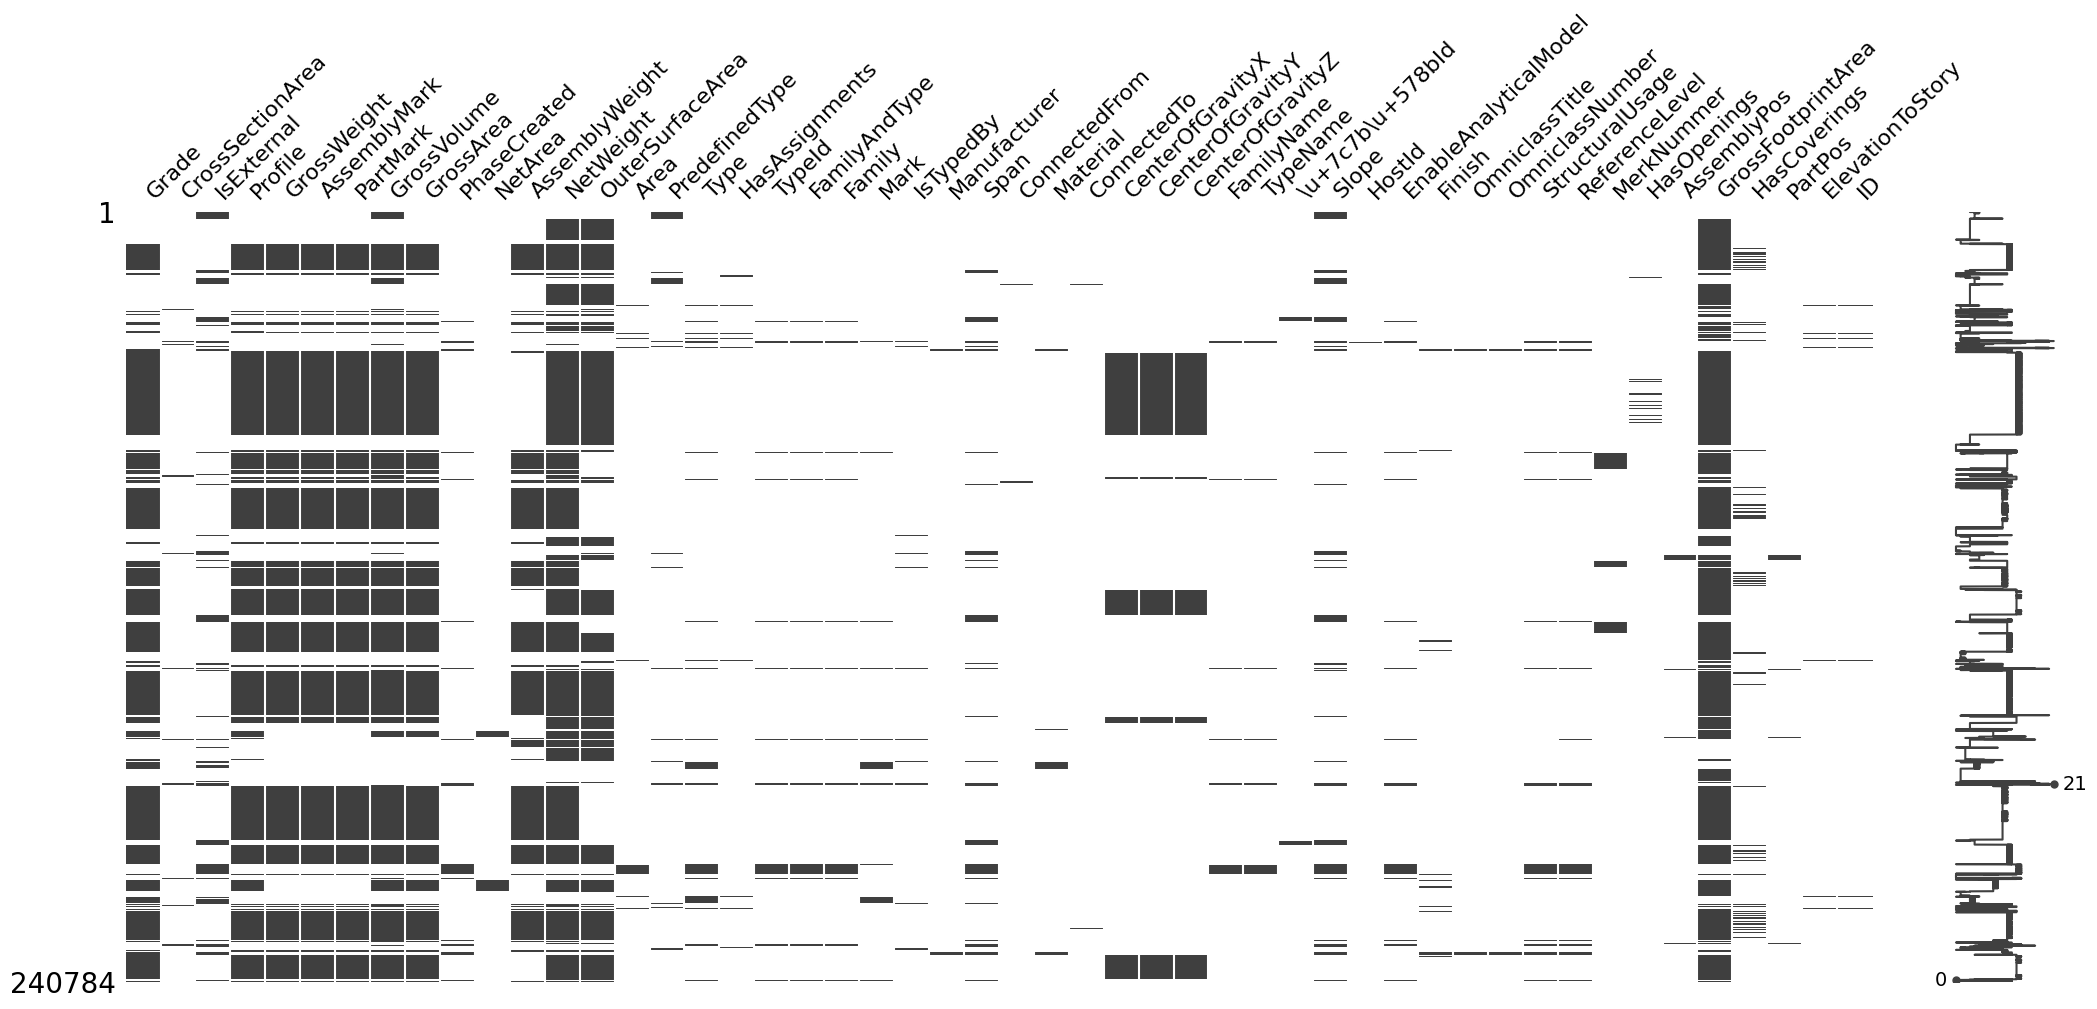

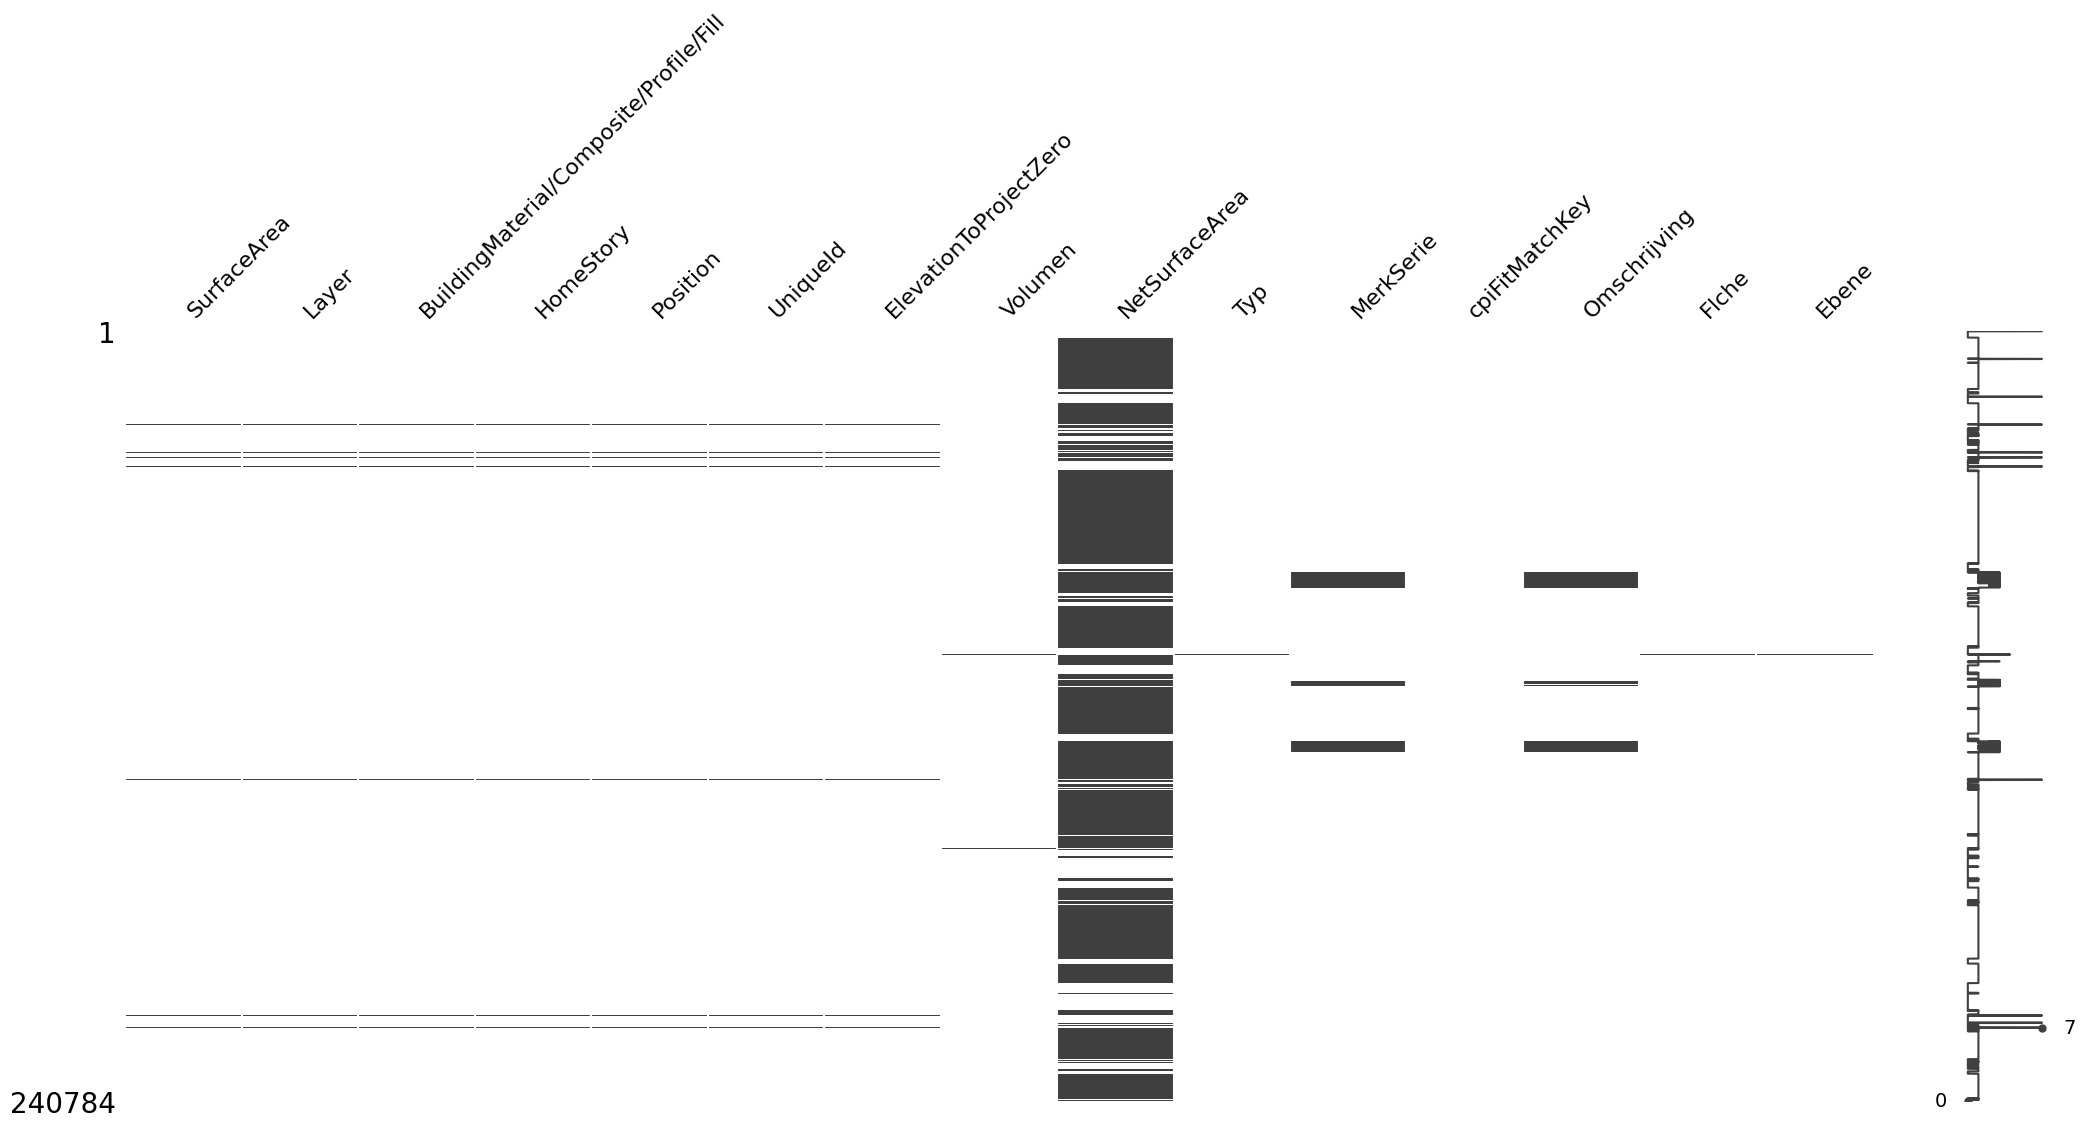

In [89]:
import missingno as msn
msn.matrix(df_beams.iloc[:, :50])
msn.matrix(df_beams.iloc[:, 50:100])
msn.matrix(df_beams.iloc[:, 100:])

## Сохраняем очищенные данные

In [90]:
df_beams.to_csv("data/IFC_2000_300_Columns_Beams.csv")